In [2]:
import torch
import numpy as np
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models

import torch
import numpy as np
import cv2
import random
import math
from torch.utils.data import Dataset, DataLoader


In [ ]:
def make_km_family(W: int, H: int, K: int) -> np.ndarray:
    """
    Generates K Kaplan-Meier style curves (staircase).
    """
    ys = np.zeros((K, W), np.float32)
    # Ensure separation at the start (t=0)
    starts = np.sort(np.random.uniform(0.1, 0.4, K) * H)
    
    for k in range(K):
        y = starts[k]
        curr_curve = np.full(W, y)
        # Determine number of 'events' (steps)
        n_steps = random.randint(3, 12)
        step_locations = sorted(random.sample(range(10, W-10), n_steps))
        
        for loc in step_locations:
            # KM curves only go down (or up if inversed)
            drop = random.uniform(0.05, 0.15) * H
            y = min(H - 5, y + drop) # Downward in pixel space is +y
            curr_curve[loc:] = y
            
        ys[k] = curr_curve

    # Local Confusion: Occasionally make curves merge or cross 
    # (Though KM usually don't cross, models must handle it)
    if K >= 2 and random.random() < 0.3:
        a, b = random.sample(range(K), 2)
        mid = (ys[a] + ys[b]) / 2
        ys[a] = ys[b] = mid # Forced merge
        
    return ys

# Helper functions for the realistic rendering pipeline
def smooth_random_drift_internal(W, amp, sigma):
    d = np.random.normal(0, 1, (W,)).astype(np.float32)
    d = cv2.GaussianBlur(d.reshape(1, -1), (0, 0), sigmaX=sigma).reshape(-1)
    d = d / (np.std(d) + 1e-6)
    return d * amp

def random_color_gen():
    return tuple(int(x) for x in np.random.randint(30, 220, size=3))

def render_full_image_no_axes_internal(
    H,
    W,
    ys,
    colors,
    *,
    thickness_range=(2, 3),
    linestyle_probs=(0.6, 0.25, 0.15),   # solid, dashed, dotted
    ci_prob=0.25,
    ci_style="bars",                    # "bars" or "band"
    marker_prob=0.0,
    legend_prob=0.0,                    # ignored here but kept for API consistency
    noise=True,
):
    """
    Render curves on a plain background (no axes).

    Backward compatible with old call:
        render_full_image_no_axes_internal(H, W, ys, colors)

    Extended options are keyword-only.
    """

    img = np.ones((H, W, 3), np.uint8) * 255
    K = ys.shape[0]

    # -----------------------------
    # linestyle sampling
    # -----------------------------
    styles = ["solid", "dashed", "dotted"]
    style_weights = np.array(linestyle_probs, dtype=np.float32)
    style_weights /= style_weights.sum()

    for k in range(K):
        color = colors[k]
        thickness = random.randint(*thickness_range)

        y = ys[k]
        pts = np.stack([np.arange(W), y], axis=1).astype(np.int32)

        style = random.choices(styles, weights=style_weights, k=1)[0]

        # -----------------------------
        # main stroke
        # -----------------------------
        if style == "solid":
            cv2.polylines(img, [pts], False, color, thickness, cv2.LINE_AA)

        elif style == "dashed":
            dash = random.randint(10, 18)
            gap = random.randint(8, 16)
            i = 0
            while i < W - 1:
                j = min(W, i + dash)
                cv2.polylines(img, [pts[i:j]], False, color, thickness, cv2.LINE_AA)
                i = j + gap

        elif style == "dotted":
            step = random.randint(10, 18)
            r = max(1, thickness // 2)
            for i in range(0, W, step):
                cv2.circle(
                    img,
                    (int(pts[i, 0]), int(pts[i, 1])),
                    r,
                    color,
                    -1,
                    cv2.LINE_AA,
                )

        # -----------------------------
        # optional markers
        # -----------------------------
        if marker_prob > 0 and random.random() < marker_prob:
            step = random.randint(30, 70)
            for i in range(0, W, step):
                x, y0 = int(pts[i, 0]), int(pts[i, 1])
                cv2.circle(img, (x, y0), 2, color, 1, cv2.LINE_AA)

        # -----------------------------
        # confidence interval
        # -----------------------------
        if ci_prob > 0 and random.random() < ci_prob:
            if ci_style == "bars":
                for x in range(
                    random.randint(0, 20),
                    W,
                    random.randint(60, 100),
                ):
                    y0 = int(y[x])
                    cv2.line(
                        img,
                        (x, y0 - 12),
                        (x, y0 + 12),
                        color,
                        1,
                        cv2.LINE_AA,
                    )

            elif ci_style == "band":
                _draw_ci_band_internal(img, y, color)

    # -----------------------------
    # image-level noise
    # -----------------------------
    if noise:
        img = add_image_noise_internal(img)

    return img

def add_image_noise_internal(img):
    # Quick implementation of the noise models from the new script
    out = img.copy()
    if random.random() < 0.3: # Blur
        out = cv2.GaussianBlur(out, (3, 3), 0)
    if random.random() < 0.3: # Speckle
        noise = np.random.normal(0, 5, out.shape).astype(np.uint8)
        out = cv2.add(out, noise)
    return out

In [152]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset


# =========================
# 1) Motif-based curve synthesis
# =========================

@dataclass
class Motif:
    kind: str
    length: int
    params: dict


def clamp(x, lo, hi):
    return max(lo, min(x, hi))


def _smooth1d(x: np.ndarray, k: int) -> np.ndarray:
    """Always returns same length as x, never crashes."""
    L = len(x)
    if L < 3:
        return x
    k = int(k) | 1
    k = min(k, L | 1)
    kernel = np.ones(k, np.float32) / k
    y = np.convolve(x, kernel, mode="same")
    return y[:L]

def safe_split(L: int, lo_frac=0.3, hi_frac=0.7) -> int:
    """Returns cut such that 1 <= cut <= L-1, or 0 if impossible."""
    if L < 2:
        return 0
    cut = int(L * random.uniform(lo_frac, hi_frac))
    return clamp(cut, 1, L - 1)

def _make_motif_sequence(W: int, km_like: bool) -> List[Motif]:
    """
    Generate an ordered list of motifs whose total length is approx W.
    KM-like = stepwise / plateau-dominated (NOT monotone).
    """
    seq: List[Motif] = []
    remaining = W

    if km_like:
        kinds = ["plateau", "jump", "stair", "kink", "spike", "osc"]
        weights = [0.32,     0.24,    0.22,    0.12,   0.04,    0.06]
    else:
        kinds = ["plateau", "ramp", "kink", "osc", "spike", "jump", "stair"]
        weights = [0.22,     0.20,   0.18,  0.18,  0.07,   0.08,   0.07]

    while remaining > 0:
        kind = random.choices(kinds, weights=weights, k=1)[0]

        if kind in ["jump", "spike"]:
            length = random.randint(6, 18)
        elif kind == "stair":
            length = random.randint(40, 130)
        else:
            length = random.randint(25, 120)

        length = min(length, remaining)

        params = {}
        if kind == "plateau":
            params["drift"] = random.uniform(-0.05, 0.05)

        elif kind == "ramp":
            params["dy"] = random.uniform(-50, 50)

        elif kind == "kink":
            params["dy1"] = random.uniform(-35, 35)
            params["dy2"] = random.uniform(-35, 35)

        elif kind == "jump":
            params["amp"] = random.uniform(15, 85) * random.choice([-1, 1])
            params["tilt"] = random.uniform(-0.15, 0.15)

        elif kind == "stair":
            params["n_steps"] = random.randint(3, 9)
            params["step_mag"] = random.uniform(8, 35) * random.choice([-1, 1])

        elif kind == "osc":
            params["amp"] = random.uniform(2.5, 14.0)
            params["rough"] = random.uniform(0.4, 1.0)
            params["bias"] = random.uniform(-0.08, 0.08)

        elif kind == "spike":
            params["amp"] = random.uniform(-60, 60)
            params["width"] = random.randint(7, 21) | 1

        seq.append(Motif(kind=kind, length=length, params=params))
        remaining -= length

    return seq

def _render_motifs_to_curve(W: int, H: int, seq: List[Motif], y0: float) -> np.ndarray:
    """
    Render motif sequence into a y(x) curve.
    Safe under all random seeds.
    """
    y = float(y0)
    out = np.zeros((W,), np.float32)

    i = 0
    for m in seq:
        lo = i
        hi = min(W, i + max(0, int(m.length)))
        L = hi - lo
        if L <= 0:
            break

        # ---------------- PLATEAU ----------------
        if m.kind == "plateau":
            drift = m.params["drift"]
            seg = y + np.linspace(0, drift * L, L)
            seg += np.random.normal(0, random.uniform(0.2, 0.9), L)

        # ---------------- RAMP ----------------
        elif m.kind == "ramp":
            seg = np.linspace(y, y + m.params["dy"], L)
            seg += _smooth1d(np.random.normal(0, 1.0, L), random.randint(5, 13))
            y = seg[-1]

        # ---------------- KINK ----------------
        elif m.kind == "kink":
            if L < 2:
                seg = np.full(L, y)
            else:
                cut = random.randint(1, L - 1)
                seg1 = np.linspace(y, y + m.params["dy1"], cut)
                seg2 = np.linspace(seg1[-1], seg1[-1] + m.params["dy2"], L - cut)
                seg = np.concatenate([seg1, seg2])
                seg += _smooth1d(np.random.normal(0, 1.0, L), random.randint(3, 9))
                y = seg[-1]

        # ---------------- JUMP ----------------
        elif m.kind == "jump":
            fall = random.randint(1, min(10, L))
            seg1 = np.linspace(
                y,
                y + m.params["amp"] + m.params["tilt"] * fall,
                fall,
            )
            seg2 = np.full(L - fall, seg1[-1])
            seg = np.concatenate([seg1, seg2])
            seg += _smooth1d(np.random.normal(0, 1.0, L), 5)
            y = seg[-1]

        # ---------------- STAIR ----------------
        elif m.kind == "stair":
            n = m.params["n_steps"]
            step = m.params["step_mag"]
            cuts = np.linspace(0, L, n + 1).astype(int)
            segs = []
            yy = y
            for a, b in zip(cuts[:-1], cuts[1:]):
                segs.append(np.full(b - a, yy))
                yy += step * random.uniform(0.6, 1.4)
            seg = np.concatenate(segs)[:L]
            seg += np.random.normal(0, random.uniform(0.15, 0.8), L)
            if random.random() < 0.35:
                seg += np.linspace(0, random.uniform(-1.5, 1.5), L)
            y = seg[-1]

        # ---------------- OSC ----------------
        elif m.kind == "osc":
            base = y + np.linspace(0, m.params["bias"] * L, L)
            n = _smooth1d(np.random.normal(0, 1.0, L), random.randint(7, 21))
            mod = _smooth1d(np.random.normal(0, 1.0, L), random.randint(9, 31))
            mod = (mod - mod.min()) / (mod.std() + 1e-6)
            seg = base + (n * (m.params["amp"] * (0.4 + 0.6 * np.tanh(mod)))) * m.params["rough"]
            seg += np.random.normal(0, random.uniform(0.5, 2.2), L)
            y = seg[-1]

        elif m.kind == "spike":
            amp = float(m.params["amp"])

            # Choose an odd width <= L
            width = int(m.params["width"])
            width = max(1, width)
            width = min(width, L)
            if width % 2 == 0:
                width -= 1
            width = max(1, width)

            seg = np.full((L,), y, np.float32)

            if width == 1:
                seg[random.randint(0, L - 1)] += amp
            else:
                x = np.linspace(-1.0, 1.0, width, dtype=np.float32)
                bump = (amp * np.exp(-6.0 * (x ** 2))).astype(np.float32)

                c = random.randint(0, L - 1)
                w2 = width // 2

                # Destination slice
                a = max(0, c - w2)
                b = min(L, c + w2 + 1)
                dst_len = b - a
                if dst_len <= 0:
                    # Extremely defensive fallback
                    seg[c] += amp
                else:
                    # Source slice constructed to match dst_len exactly
                    sa = w2 - (c - a)
                    sb = sa + dst_len

                    # Clamp to bump bounds, then clamp dst accordingly to keep same length
                    sa_clamped = max(0, sa)
                    sb_clamped = min(width, sb)

                    src_len = sb_clamped - sa_clamped
                    if src_len <= 0:
                        seg[c] += amp
                    else:
                        # Adjust destination length to match clamped source length
                        b2 = a + src_len
                        seg[a:b2] += bump[sa_clamped:sb_clamped]

            seg += np.random.normal(0, random.uniform(0.4, 1.8), L).astype(np.float32)

        else:
            seg = np.full(L, y)

        out[lo:hi] = seg
        y = float(seg[-1])
        i = hi

    # -------- Global smooth warp --------
    if random.random() < 0.35:
        warp = _smooth1d(np.random.normal(0, 1.0, W), random.randint(15, 41))
        warp = warp / (warp.std() + 1e-6) * random.uniform(0.2, 1.2)
        out += warp

    return np.clip(out, 5, H - 5).astype(np.float32)

def make_curve_family(full_w: int, full_h: int, K: int) -> np.ndarray:
    """
    Generate K related curves with shared motif structure and local interactions.
    """
    ys = np.zeros((K, full_w), np.float32)

    km_like = random.random() < 0.5
    base_seq = _make_motif_sequence(full_w, km_like)

    spacing = random.uniform(12, 30)
    offsets = np.linspace(-(K - 1) / 2, (K - 1) / 2, K) * spacing
    random.shuffle(offsets)

    for k in range(K):
        seq = []
        for m in base_seq:
            mp = dict(m.params)
            if m.kind in ["jump", "ramp", "kink", "stair", "osc", "spike"]:
                jitter = random.uniform(0.85, 1.15)
                for kk, vv in mp.items():
                    if isinstance(vv, (int, float)) and kk not in ["width", "n_steps"]:
                        mp[kk] = vv * jitter
            seq.append(Motif(m.kind, m.length, mp))

        y_start = random.uniform(0.2, 0.8) * full_h + offsets[k] + random.uniform(-6, 6)
        ys[k] = _render_motifs_to_curve(full_w, full_h, seq, y_start)

    # -------- Local interactions --------
    if K >= 2 and random.random() < 0.70:
        for _ in range(random.randint(1, 3)):
            a, b = random.sample(range(K), 2)
            cx = random.randint(full_w // 6, 5 * full_w // 6)
            bw = random.randint(35, 140)
            lo, hi = max(0, cx - bw // 2), min(full_w, cx + bw // 2)
            t = np.linspace(-1, 1, hi - lo)
            blend = np.exp(-0.5 * (t / random.uniform(0.25, 0.55)) ** 2)

            if random.random() < 0.55:
                mid = 0.5 * (ys[a, lo:hi] + ys[b, lo:hi])
                ys[a, lo:hi] = ys[a, lo:hi] * (1 - blend) + mid * blend
                ys[b, lo:hi] = ys[b, lo:hi] * (1 - blend) + mid * blend
            else:
                ya, yb = ys[a, lo:hi].copy(), ys[b, lo:hi].copy()
                ys[a, lo:hi] = ya * (1 - blend) + yb * blend
                ys[b, lo:hi] = yb * (1 - blend) + ya * blend

    return np.clip(ys, 5, full_h - 5)


# =========================
# 2) Background + rendering realism (no axes, but realistic "plot image")
# =========================

def random_color_gen():
    # avoid extremely bright/white-like strokes
    return tuple(int(x) for x in np.random.randint(25, 230, size=3))

def _make_background(H: int, W: int) -> np.ndarray:
    """
    Realistic background: off-white/gray base, gentle gradients, paper/scan texture,
    speckle, faint banding. No grid/axes by default.
    """
    # base tone
    base = random.randint(235, 255)
    img = np.ones((H, W, 3), np.uint8) * base

    # gentle illumination gradient (scanner / camera)
    if random.random() < 0.85:
        gx = np.linspace(0, 1, W, dtype=np.float32)
        gy = np.linspace(0, 1, H, dtype=np.float32)
        Gx, Gy = np.meshgrid(gx, gy)
        ang = random.uniform(0, 2 * math.pi)
        grad = (math.cos(ang) * Gx + math.sin(ang) * Gy).astype(np.float32)
        grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
        strength = random.uniform(2.0, 18.0)
        img = np.clip(img.astype(np.float32) - strength * (grad[..., None] - 0.5), 0, 255).astype(np.uint8)

    # paper texture: blurred noise field
    if random.random() < 0.80:
        tex = np.random.normal(0, 1.0, (H, W)).astype(np.float32)
        sig = random.uniform(6.0, 22.0)
        tex = cv2.GaussianBlur(tex, (0, 0), sigmaX=sig, sigmaY=sig)
        tex = tex / (tex.std() + 1e-6)
        amp = random.uniform(1.0, 6.0)
        img = np.clip(img.astype(np.float32) + amp * tex[..., None], 0, 255).astype(np.uint8)

    # faint banding (printer/scan lines)
    if random.random() < 0.25:
        band = np.random.normal(0, 1.0, (H, 1)).astype(np.float32)
        band = cv2.GaussianBlur(band, (1, 0), sigmaX=0, sigmaY=random.uniform(5.0, 25.0))
        band = band / (band.std() + 1e-6)
        img = np.clip(img.astype(np.float32) + random.uniform(0.5, 2.5) * band[..., None], 0, 255).astype(np.uint8)

    return img

def _draw_polyline_styled(img: np.ndarray, pts: np.ndarray, color: Tuple[int, int, int], thickness: int, style: str):
    """Draw solid/dashed/dotted polyline with OpenCV."""
    W = img.shape[1]

    if style == "solid":
        cv2.polylines(img, [pts], False, color, thickness, cv2.LINE_AA)
        return

    if style == "dashed":
        dash = random.randint(10, 18)
        gap = random.randint(8, 16)
        i = 0
        while i < W - 1:
            j = min(W, i + dash)
            cv2.polylines(img, [pts[i:j]], False, color, thickness, cv2.LINE_AA)
            i = j + gap
        return

    if style == "dotted":
        step = random.randint(10, 18)
        r = max(1, thickness // 2)
        for i in range(0, W, step):
            x, y = int(pts[i, 0]), int(pts[i, 1])
            cv2.circle(img, (x, y), r, color, -1, cv2.LINE_AA)
        return

    # fallback
    cv2.polylines(img, [pts], False, color, thickness, cv2.LINE_AA)


def _draw_markers(img, pts, color, thickness):
    """
    Tracking-safe markers:
    - max total height <= 4 px
    - independent of line thickness
    """
    marker_step = random.randint(30, 70)

    size = random.randint(1, 2)   # radius / half-size
    size = min(size, 2)           # hard clamp

    kind = random.choice(["circle", "square", "triangle", "x"])

    for i in range(0, len(pts), marker_step):
        x, y = int(pts[i, 0]), int(pts[i, 1])

        if kind == "circle":
            cv2.circle(img, (x, y), size, color, 1, cv2.LINE_AA)

        elif kind == "square":
            cv2.rectangle(
                img,
                (x - size, y - size),
                (x + size, y + size),
                color,
                1,
                cv2.LINE_AA,
            )

        elif kind == "triangle":
            tri = np.array(
                [[x, y - size], [x - size, y + size], [x + size, y + size]],
                np.int32,
            )
            cv2.polylines(img, [tri], True, color, 1, cv2.LINE_AA)

        else:  # 'x'
            cv2.line(img, (x - size, y - size), (x + size, y + size), color, 1, cv2.LINE_AA)
            cv2.line(img, (x - size, y + size), (x + size, y - size), color, 1, cv2.LINE_AA)

def _draw_ci_band(img: np.ndarray, y: np.ndarray, color: Tuple[int, int, int], alpha: float = 0.18):
    """Shaded confidence band around a curve (more realistic than vertical bars)."""
    H, W = img.shape[:2]
    # band width varies smoothly
    bw = np.random.normal(0, 1.0, W).astype(np.float32)
    bw = cv2.GaussianBlur(bw.reshape(1, -1), (0, 0), sigmaX=random.uniform(10, 35)).reshape(-1)
    bw = bw / (bw.std() + 1e-6)
    half = np.clip(3 + 2 * bw, 2, 8).astype(np.int32)

    y0 = np.clip(y.astype(np.int32) - half, 0, H - 1)
    y1 = np.clip(y.astype(np.int32) + half, 0, H - 1)

    upper = np.stack([np.arange(W), y0], axis=1)
    lower = np.stack([np.arange(W)[::-1], y1[::-1]], axis=1)
    poly = np.concatenate([upper, lower], axis=0).astype(np.int32)

    overlay = img.copy()
    cv2.fillPoly(overlay, [poly], color)
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, dst=img)

def _draw_legend_box(img: np.ndarray, colors: List[Tuple[int, int, int]], labels: List[str]):
    """
    Black box somewhere with text; includes small color swatches.
    Intentionally can occlude curves to improve tracking robustness.
    """
    H, W = img.shape[:2]
    n = min(len(labels), random.randint(1, min(6, len(labels))))
    idxs = random.sample(range(len(labels)), n)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = random.uniform(0.35, 0.55)
    thick = 1

    line_h = int(18 * font_scale + 10)
    box_w = random.randint(int(W * 0.18), int(W * 0.35))
    box_h = int(12 + n * line_h)

    # random placement
    x0 = random.randint(0, max(0, W - box_w - 1))
    y0 = random.randint(0, max(0, H - box_h - 1))

    overlay = img.copy()
    # black (or very dark) box with slight transparency
    cv2.rectangle(overlay, (x0, y0), (x0 + box_w, y0 + box_h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, random.uniform(0.65, 0.9), img, 1 - random.uniform(0.65, 0.9), 0, dst=img)

    # draw entries
    y = y0 + 10 + int(line_h * 0.7)
    for j, i in enumerate(idxs):
        c = colors[i]
        # swatch line
        cv2.line(img, (x0 + 10, y - 5), (x0 + 40, y - 5), c, 2, cv2.LINE_AA)
        # label
        cv2.putText(img, labels[i], (x0 + 48, y),
                    font, font_scale, (255, 255, 255), thick, cv2.LINE_AA)
        y += line_h

def add_image_noise_internal(img: np.ndarray) -> np.ndarray:
    """
    Image-level artifacts: blur, sensor noise, salt/pepper, jpeg compression.
    """
    out = img.copy()

    # Mild blur (camera focus / JPEG smoothing)
    if random.random() < 0.35:
        k = random.choice([3, 5])
        out = cv2.GaussianBlur(out, (k, k), 0)

    # Additive sensor noise (Gaussian)
    if random.random() < 0.60:
        sigma = random.uniform(1.0, 6.0)
        noise = np.random.normal(0, sigma, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Speckle / multiplicative-ish
    if random.random() < 0.35:
        s = random.uniform(0.01, 0.05)
        n = np.random.normal(0, 1.0, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + out.astype(np.float32) * (s * n), 0, 255).astype(np.uint8)

    # Salt & pepper
    if random.random() < 0.15:
        p = random.uniform(0.0005, 0.003)
        mask = np.random.rand(*out.shape[:2])
        out[mask < p] = 0
        out[mask > 1 - p] = 255

    # JPEG compression artifacts
    if random.random() < 0.55:
        q = random.randint(35, 90)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
        ok, enc = cv2.imencode(".jpg", out, encode_param)
        if ok:
            out = cv2.imdecode(enc, cv2.IMREAD_COLOR)

    return out

def render_full_image_no_axes_internal(
    H: int,
    W: int,
    ys: np.ndarray,
    colors: List[Tuple[int, int, int]],
    thickness_range=(1, 3),
    marker_prob=0.40,
    ci_prob=0.30,
    legend_prob=0.35,
) -> np.ndarray:
    """
    Render curves on realistic background (no axes), with optional CI bands, markers, and legend box.
    """
    img = _make_background(H, W)
    K = ys.shape[0]

    # Labels for legend (simple but realistic)
    label_pool = ["Control", "Treatment", "Model A", "Model B", "Group 1", "Group 2", "Baseline", "Variant"]
    labels = []
    for k in range(K):
        if random.random() < 0.7:
            labels.append(random.choice(label_pool))
        else:
            labels.append(f"Series {k+1}")

    # Draw confidence bands first (under curves)
    for k in range(K):
        if random.random() < ci_prob:
            _draw_ci_band(img, ys[k], colors[k], alpha=random.uniform(0.10, 0.22))

    for k in range(K):
        color = colors[k]
        thickness = random.randint(*thickness_range)
        pts = np.stack([np.arange(W), ys[k]], axis=1).astype(np.int32)

        style = random.choices(["solid", "dashed", "dotted"], weights=[0.62, 0.25, 0.13], k=1)[0]
        _draw_polyline_styled(img, pts, color, thickness, style)

        # Markers: low probability and low density
        if random.random() < marker_prob:
            _draw_markers(img, pts, color, thickness)

        # Occasional tiny occluders (tracking realism): small smudges / overdraw
        if random.random() < 0.12:
            x = random.randint(0, W - 1)
            y = int(np.clip(ys[k, x], 0, H - 1))
            r = random.randint(6, 16)
            sm = img.copy()
            cv2.circle(sm, (x, y), r, (random.randint(0, 40),) * 3, -1, cv2.LINE_AA)
            cv2.addWeighted(sm, random.uniform(0.10, 0.30), img, 1 - random.uniform(0.10, 0.30), 0, dst=img)

    # Legend box (can occlude curves)
    if K >= 1 and random.random() < legend_prob:
        _draw_legend_box(img, colors, labels)

    img = add_image_noise_internal(img)
    return img


# =========================
# 3) Priors for tracking (drift + structural mistakes)
# =========================

def smooth_random_drift_internal(W, amp, sigma):
    d = np.random.normal(0, 1, (W,)).astype(np.float32)
    d = cv2.GaussianBlur(d.reshape(1, -1), (0, 0), sigmaX=sigma).reshape(-1)
    d = d / (np.std(d) + 1e-6)
    return d * amp


# =========================
# 4) Dataset (same interface as yours)
# =========================
import torch
import numpy as np
import random
import cv2
from torch.utils.data import Dataset

class KMHybridDataset(Dataset):
    """
    Standalone Kaplan-Meier Dataset.
    Generates B&W images of staircase curves with 'Ghost Line' noise.
    Mixes easy cases (wide separation) with hard cases (near-crossing/sharing).
    """
    def __init__(
        self, 
        n_samples=5000, 
        h=256, 
        w=512, 
        win_w=64, 
        max_curves=3, 
        context_prob=0.4, 
        add_legend_noise=True
    ):
        self.n = n_samples
        self.h = h
        self.w = w
        self.win_w = win_w
        self.max_curves = max_curves
        self.context_prob = context_prob
        self.add_legend_noise = add_legend_noise
        
        # Target segment length (we usually predict the center point)
        self.seg_len = 5 
        self.seg_r = self.seg_len // 2

    def __len__(self):
        return self.n

    def _generate_km_curves(self, K):
        """Generates the staircase Y-coordinates."""
        ys = np.zeros((K, self.w), np.float32)
        
        # Determine if this specific sample is 'Hard' (close curves) or 'Easy' (wide gaps)
        is_hard = random.random() < self.context_prob
        
        if is_hard:
            # HARD: Curves are clustered (4-12px apart), requires context to resolve
            base_y = random.uniform(0.15, 0.4) * self.h
            offsets = np.linspace(0, random.uniform(8, 16), K)
        else:
            # EASY: Curves are far apart (30-50px), simple snapping
            base_y = random.uniform(0.1, 0.3) * self.h
            offsets = np.sort(random.sample(range(0, 150, 40), K))

        for k in range(K):
            y = base_y + offsets[k]
            curve = np.full(self.w, y)
            
            # Number of steps (drops)
            n_steps = random.randint(2, 7)
            step_locs = sorted(random.sample(range(20, self.w - 20), n_steps))
            
            for loc in step_locs:
                # In hard cases, drops can be larger to force curves to 'pass' each other's priors
                drop_scale = random.uniform(0.04, 0.12) if is_hard else random.uniform(0.02, 0.06)
                drop = drop_scale * self.h
                y = min(self.h - 10, y + drop)
                curve[loc:] = y
            ys[k] = curve
            
        return ys

    def _draw_bw_image(self, ys):
        """Renders the curves into a 1-channel B&W image with noise."""
        img = np.zeros((self.h, self.w), np.uint8)
        
        for k in range(ys.shape[0]):
            # Render staircase with 1px precision
            pts = np.stack([np.arange(self.w), ys[k]], axis=1).astype(np.int32)
            cv2.polylines(img, [pts], False, 255, 1, cv2.LINE_4)
            
        if self.add_legend_noise:
            # 1. Ghost Horizontal Lines (Legend borders or grid fragments)
            for _ in range(random.randint(1, 4)):
                y_noise = random.randint(10, self.h - 10)
                x_start = random.randint(0, self.w - 120)
                length = random.randint(30, 180)
                cv2.line(img, (x_start, y_noise), (x_start + length, y_noise), 255, 1)
            
            # 2. Ghost Vertical Ticks
            for _ in range(random.randint(2, 6)):
                x_noise = random.randint(10, self.w - 10)
                y_start = random.randint(0, self.h - 30)
                cv2.line(img, (x_noise, y_start), (x_noise, y_start + 12), 255, 1)
                
        return img

    def __getitem__(self, idx):
        num_curves = random.randint(1, self.max_curves)
        
        # 1. Generate Staircase GT
        ys_true = self._generate_km_curves(num_curves)
        
        # 2. Render to B&W Image
        img_bw = self._draw_bw_image(ys_true)
        
        # 3. Create Priors (GT + horizontal trend-preserving drift)
        priors_full = ys_true.copy()
        for k in range(num_curves):
            # Smooth drift ensures the prior 'vaguely' follows the staircase
            # but is often 5-15px off target
            drift = np.cumsum(np.random.normal(0, 0.4, self.w)) 
            bias = random.uniform(-12, 12)
            priors_full[k] += (drift + bias)
            
        # 4. Extract Tracking Window
        x_center = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_center - self.win_w // 2, x_center + self.win_w // 2
        
        # Image Window: [1, H, win_w]
        img_win = img_bw[:, x0:x1]
        img_t = torch.from_numpy(img_win).unsqueeze(0).float() / 255.0
        
        # 5. Pack Tensors
        priors_t = torch.zeros((self.max_curves, self.win_w))
        targets_t = torch.zeros((self.max_curves, self.seg_len))
        mask = torch.zeros(self.max_curves)
        
        for k in range(num_curves):
            # The prior segment the model sees
            priors_t[k] = torch.from_numpy(priors_full[k, x0:x1]).float() / (self.h - 1)
            
            # The GT segment (5px width) for the loss function
            xs = np.arange(x_center - self.seg_r, x_center + self.seg_r + 1).clip(0, self.w - 1)
            targets_t[k] = torch.from_numpy(ys_true[k, xs]).float() / (self.h - 1)
            
            mask[k] = 1.0
            
        return img_t, priors_t, targets_t, mask




In [156]:
import torch
import numpy as np
import random
import cv2
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

# this one worked
class KMBayesianRefiner(nn.Module):
    def __init__(self, d_model=128):
        super().__init__()
        # 1. Vertical Scanner: Preserves 256px resolution
        self.scanner = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(15, 1), padding=(7, 0)),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        
        # 2. Context Engine: Negotiates curve order
        self.context_engine = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True),
            num_layers=2
        )
        
        # Mapping scanner + prior into transformer space
        self.input_proj = nn.Linear(256 + 1, 256)
        self.to_logits = nn.Linear(256, 256)

    def forward(self, img_bw, priors, mask=None):
        B, K, W = priors.shape
        mid = W // 2
        
        # 1. Visual Evidence: [B, 256]
        v_col = self.scanner(img_bw)[:, 0, :, mid]
        
        # 2. Prior Center: [B, K]
        p_centers = priors[:, :, mid]
        
        # 3. Create Curve Tokens
        # Each curve gets the visual evidence + its prior coordinate
        combined_input = torch.cat([
            v_col.unsqueeze(1).expand(-1, K, -1), 
            p_centers.unsqueeze(-1)
        ], dim=-1) # [B, K, 257]
        
        refined = self.context_engine(self.input_proj(combined_input))
        logits = self.to_logits(refined) # [B, K, 256]
        
        # 4. Apply Prior Bias (The 'Gaussian Gate')
        # This prevents the model from jumping to the wrong curve's line
        y_range = torch.linspace(0, 1, 256, device=img_bw.device).view(1, 1, 256)
        prior_bias = -((y_range - p_centers.unsqueeze(-1))**2) / (2 * (0.05**2))
        
        # Final Logits = Visual Signal + Prior Guidance
        return logits + prior_bias
    
class KMFullSceneSampler(Dataset):
    def __init__(self, n_scenes=200, samples_per_scene=50, h=256, w=512, win_w=64, max_curves=3, context_prob=0.5):
        self.h, self.w, self.win_w = h, w, win_w
        self.max_curves = max_curves
        self.samples_per_scene = samples_per_scene
        self.n_scenes = n_scenes
        self.context_prob = context_prob # Restore Hybrid capacity
        self.scenes = [self._generate_full_scene() for _ in range(n_scenes)]

    def _generate_full_scene(self):
        num_curves = random.randint(1, self.max_curves)
        is_hard = random.random() < self.context_prob # Determine scene difficulty
        
        # 1. Setup separation based on difficulty
        if is_hard:
            base_y = random.uniform(0.15, 0.4) * self.h
            offsets = np.linspace(0, random.uniform(8, 16), num_curves)
        else:
            base_y = random.uniform(0.1, 0.3) * self.h
            offsets = np.sort(random.sample(range(0, 150, 40), num_curves))

        # 2. Generate staircase
        ys_true = np.zeros((num_curves, self.w), np.float32)
        for k in range(num_curves):
            y = base_y + offsets[k]
            curve = np.full(self.w, y)
            n_steps = random.randint(3, 10)
            step_locs = sorted(random.sample(range(20, self.w-20), n_steps))
            for loc in step_locs:
                drop = (random.uniform(0.05, 0.12) if is_hard else random.uniform(0.02, 0.06)) * self.h
                y = min(self.h - 10, y + drop)
                curve[loc:] = y
            ys_true[k] = curve

        # 3. Render and Noise (Simplified B&W)
        img_bw = np.zeros((self.h, self.w), np.uint8)
        for k in range(num_curves):
            pts = np.stack([np.arange(self.w), ys_true[k]], axis=1).astype(np.int32)
            cv2.polylines(img_bw, [pts], False, 255, 1, cv2.LINE_4)
        
        # 4. Create Priors
        priors_full = ys_true.copy()
        for k in range(num_curves):
            drift = np.cumsum(np.random.normal(0, 0.4, self.w))
            bias = random.uniform(-10, 10)
            priors_full[k] += (drift + bias)
            
        return {"img": img_bw, "ys": ys_true, "priors": priors_full, "k": num_curves}

    def __len__(self):
        return self.n_scenes * self.samples_per_scene

    def __getitem__(self, idx):
        scene = self.scenes[idx // self.samples_per_scene]
        x_c = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_c - self.win_w // 2, x_c + self.win_w // 2
        
        img_t = torch.from_numpy(scene["img"][:, x0:x1]).unsqueeze(0).float() / 255.0
        priors_t = torch.zeros((self.max_curves, self.win_w))
        targets_t = torch.zeros((self.max_curves, 1))
        mask = torch.zeros(self.max_curves)
        
        for k in range(scene["k"]):
            priors_t[k] = torch.from_numpy(scene["priors"][k, x0:x1]).float() / (self.h - 1)
            targets_t[k, 0] = float(scene["ys"][k, x_c]) / (self.h - 1)
            mask[k] = 1.0
            
        return img_t, priors_t, targets_t, mask

class KMRealisticHybridDataset(Dataset):
    def __init__(self, n_scenes=200, samples_per_scene=100, h=256, w=512, win_w=64, max_curves=3, context_prob=0.7):
        self.h, self.w, self.win_w = h, w, win_w
        self.max_curves = max_curves
        self.samples_per_scene = samples_per_scene
        self.n_scenes = n_scenes
        self.context_prob = context_prob 
        self.scenes = [self._generate_full_scene() for _ in range(n_scenes)]

    def __len__(self):
        return self.n_scenes * self.samples_per_scene

    def _generate_full_scene(self):
        num_curves = random.randint(1, self.max_curves)
        is_hard = random.random() < self.context_prob
        
        # 1. Setup separation
        if is_hard:
            base_y = random.uniform(0.15, 0.4) * self.h
            # Hard cases: curves are extremely close (2-8px)
            offsets = np.linspace(0, random.uniform(4, 10), num_curves)
        else:
            base_y = random.uniform(0.1, 0.3) * self.h
            offsets = np.sort(random.sample(range(0, 150, 40), num_curves))

        ys_true = np.zeros((num_curves, self.w), np.float32)
        img_bw = np.zeros((self.h, self.w), np.uint8)

        for k in range(num_curves):
            # Generate staircase
            y = base_y + offsets[k]
            curve = np.full(self.w, y)
            n_steps = random.randint(3, 10)
            step_locs = sorted(random.sample(range(20, self.w-20), n_steps))
            for loc in step_locs:
                drop = (random.uniform(0.05, 0.15) if is_hard else random.uniform(0.02, 0.06)) * self.h
                y = min(self.h - 10, y + drop)
                curve[loc:] = y
            ys_true[k] = curve

            # --- RENDER WITH VARIABLE WIDTH ---
            # Randomize thickness (1 to 3 pixels) and intensity for each curve segment
            thickness = random.randint(1, 3)
            alpha = random.randint(180, 255)
            pts = np.stack([np.arange(self.w), ys_true[k]], axis=1).astype(np.int32)
            cv2.polylines(img_bw, [pts], False, alpha, thickness, cv2.LINE_AA)
        
        # 2. Add realistic noise (smudges and grid lines)
        if random.random() < 0.8:
            for _ in range(random.randint(5, 15)):
                cv2.circle(img_bw, (random.randint(0, self.w), random.randint(0, self.h)), 
                           random.randint(1, 3), random.randint(50, 150), -1)

        # 3. Priors with 'Contextual Jitter'
        priors_full = ys_true.copy()
        for k in range(num_curves):
            # Sometimes the prior is quite far from the truth to force trend-matching
            bias = random.uniform(-15, 15)
            if is_hard and random.random() < 0.3:
                bias = random.choice([-25, 25]) # Major distraction
            priors_full[k] += (np.cumsum(np.random.normal(0, 0.4, self.w)) + bias)
            
        return {"img": img_bw, "ys": ys_true, "priors": priors_full, "k": num_curves}

    def __getitem__(self, idx):
        scene = self.scenes[idx // self.samples_per_scene]
        x_c = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_c - self.win_w // 2, x_c + self.win_w // 2
        
        img_t = torch.from_numpy(scene["img"][:, x0:x1]).unsqueeze(0).float() / 255.0
        priors_t = torch.zeros((self.max_curves, self.win_w))
        targets_t = torch.zeros((self.max_curves, 1))
        mask = torch.zeros(self.max_curves)
        
        for k in range(scene["k"]):
            priors_t[k] = torch.from_numpy(scene["priors"][k, x0:x1]).float() / (self.h - 1)
            targets_t[k, 0] = float(scene["ys"][k, x_c]) / (self.h - 1)
            mask[k] = 1.0
            
        return img_t, priors_t, targets_t, mask

class KMContextDeepNegotiator(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        # 1. Dilated Scanner: Sees a 31px horizontal trend without more parameters
        self.scanner = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(15, 5), padding=(7, 2)),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(1, 7), padding=(0, 6), dilation=(1, 2)),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        
        # 2. Contextual Tokenization
        self.vis_proj = nn.Linear(32 * 64, d_model)
        self.pri_proj = nn.Linear(64, d_model)

        # 3. Deep Negotiation Transformer (6 layers)
        # This handles the complex logic of 'which curve gets which line'
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=8, dim_feedforward=1024, batch_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        self.heatmap_head = nn.Linear(d_model, 256)

    def forward(self, img_bw, priors, mask=None):
        B, K, W = priors.shape
        # 1. Visual trend extraction
        v_feat = self.scanner(img_bw) # [B, 32, 256, 64]
        
        # Create Y-specific tokens: [B, 256, d_model]
        # Each token represents a vertical position and its local horizontal trend
        v_tokens = self.vis_proj(v_feat.permute(0, 2, 1, 3).flatten(2))
        
        # Prior tokens
        p_tokens = self.pri_proj(priors) # [B, K, d_model]
        
        # Combined sequence
        tokens = torch.cat([v_tokens, p_tokens], dim=1) 
        
        # Masking
        attn_mask = None
        if mask is not None:
            v_pad = torch.zeros((B, 256), dtype=torch.bool, device=img_bw.device)
            attn_mask = torch.cat([v_pad, (mask <= 0)], dim=1)

        refined = self.transformer(tokens, src_key_padding_mask=attn_mask)
        
        # Heatmap prediction for the curves (last K tokens)
        logits = self.heatmap_head(refined[:, -K:]) # [B, K, 256]
        return logits
    

In [157]:
def km_soft_center_loss(y_logits, y_true, img_bw, mask, H_px=256):
    B, K, _ = y_logits.shape
    y_range = torch.linspace(0, 1, H_px, device=y_logits.device).view(1, 1, H_px)
    
    # 1. Prediction Heatmap
    probs = torch.softmax(y_logits, dim=-1)
    
    # 2. Image-Based Guidance (The Magnet)
    # We look at the center column and find the 'center of mass' of the white line
    # near the ground truth
    center_col = img_bw[:, 0, :, img_bw.shape[3]//2] / 255.0 # [B, 256]
    
    # Kullback-Leibler Divergence between predicted heatmap and target
    # Target is a Gaussian peak at GT, but 'masked' by where actual pixels are
    target_gauss = torch.exp(-0.5 * ((y_range - y_true) / 0.01)**2)
    target_probs = (target_gauss * center_col.unsqueeze(1)) + 1e-8
    target_probs = target_probs / target_probs.sum(dim=-1, keepdim=True)
    
    # KL Loss
    log_probs = torch.log_softmax(y_logits, dim=-1)
    loss = -(target_probs * log_probs).sum(dim=-1)
    
    return (loss * mask).sum() / (mask.sum() + 1e-8)

In [158]:
def train_km_snapper(
    model,
    train_dataset,
    val_loader,
    epochs=30,
    save_path="km_snapper_best.pth",
    resume_path=None
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    start_epoch = 0
    # ... (Resume logic remains the same) ...

    for epoch in range(start_epoch, epochs):
        model.train()
        # Note: Move DataLoader creation outside if your dataset is static
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        for imgs, priors, targets, masks in train_loader:
            imgs, priors, targets, masks = [x.to(device) for x in [imgs, priors, targets, masks]]
            y_true = targets[:, :, targets.shape[2]//2].unsqueeze(-1)

            # Forward: model returns logits [B, K, 256]
            y_logits = model(imgs, priors, mask=masks)
            loss = km_soft_center_loss(y_logits, y_true, imgs, masks)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # --- VALIDATION LOGIC ---
        model.eval()
        total_val_err = 0
        total_curves = 0
        
        with torch.no_grad():
            for imgs, priors, targets, masks in val_loader:
                imgs, priors, targets, masks = [x.to(device) for x in [imgs, priors, targets, masks]]
                
                # Get Heatmap Logits [B, K, 256]
                y_logits = model(imgs, priors, mask=masks)
                
                # 1. Decode Heatmap -> Expected Value Y [B, K]
                probs = F.softmax(y_logits, dim=-1)
                y_range = torch.linspace(0, 1, 256, device=device).view(1, 1, 256)
                # Weighted sum across the 256 bins for each curve
                y_pred_decoded = (probs * y_range).sum(dim=-1) # [B, K]
                
                # 2. Align GT shape [B, K]
                y_true_center = targets[:, :, targets.shape[2]//2] # [B, K]
                
                # 3. Calculate Error [B, K]
                err = torch.abs(y_pred_decoded - y_true_center) * masks
                
                total_val_err += err.sum().item()
                total_curves += masks.sum().item()

        avg_val_err = (total_val_err / (total_curves + 1e-6)) * 255 
        print(f"Epoch {epoch} | Val Error: {avg_val_err:.2f} px")
        
        scheduler.step()
        torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, save_path)

    return model

In [159]:
def visualize_full_image_inference(model, dataset, scene_idx=None):
    """
    Takes a full HxW scene, slides a window across it, and predicts 
    all K curves across the entire width.
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Select a scene
    if scene_idx is None:
        scene_idx = random.randint(0, dataset.n_scenes - 1)
    scene = dataset.scenes[scene_idx]
    
    H, W = dataset.h, dataset.w
    win_w = dataset.win_w
    half_win = win_w // 2
    K = scene["k"]
    
    # Containers for full-width predictions
    # We initialize with NaNs so we only plot where we have predictions
    full_preds_px = np.full((K, W), np.nan)
    
    # 2. Sliding Window Inference
    # We step through the image, predicting the center point of each window
    with torch.no_grad():
        for x_c in range(half_win, W - half_win):
            x0, x1 = x_c - half_win, x_c + half_win
            
            # Prepare inputs
            img_t = torch.from_numpy(scene["img"][:, x0:x1]).unsqueeze(0).unsqueeze(0).float() / 255.0
            priors_t = torch.zeros((dataset.max_curves, win_w))
            mask = torch.zeros(dataset.max_curves)
            
            for k in range(K):
                priors_t[k] = torch.from_numpy(scene["priors"][k, x0:x1]).float() / (H - 1)
                mask[k] = 1.0
                
            img_t = img_t.to(device)
            priors_t = priors_t.unsqueeze(0).to(device)
            mask_t = mask.unsqueeze(0).to(device)
            
            # Forward pass -> Heatmap [1, K, 256]
            y_logits = model(img_t, priors_t, mask=mask_t)
            probs = torch.softmax(y_logits, dim=-1)
            
            # Decode Expected Value
            y_range = torch.linspace(0, 1, 256, device=device).view(1, 1, 256)
            y_pred_center = (probs * y_range).sum(dim=-1) # [1, K]
            
            # Store in pixels
            full_preds_px[:, x_c] = y_pred_center[0, :K].cpu().numpy() * (H - 1)

    # 3. Plotting
    colors = cm.get_cmap("tab10")
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Show the full B&W background
    ax.imshow(scene["img"], cmap='gray', alpha=0.9)
    
    for k in range(K):
        c = colors(k)
        # Plot full GT (Solid thin)
        ax.plot(scene["ys"][k], color='white', linewidth=0.5, alpha=0.5, label=f"GT {k}" if k==0 else "")
        
        # Plot full Prior (Dotted)
        ax.plot(scene["priors"][k], ":", color=c, alpha=0.3, label=f"Prior {k}")
        
        # Plot Model Full-Width Prediction (Solid thick)
        # The line will naturally follow the B&W pixels if the model is snapping
        ax.plot(full_preds_px[k], color=c, linewidth=2.5, label=f"Snapped {k}")

    ax.set_title(f"Full Scene Inference | Scene ID: {scene_idx} | KM Staircase Snapping")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(H - 1, 0)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.functional as F

def visualize_attention_map(model, dataset, num_samples=2):
    model.eval()
    device = next(model.parameters()).device
    h, win_w = dataset.h, dataset.win_w
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples), 
                             gridspec_kw={'width_ratios': [1, 3]})

    with torch.no_grad():
        for i in range(num_samples):
            idx = random.randint(0, len(dataset) - 1)
            img_t, priors_t, targets_t, mask = dataset[idx]

            # Forward with feature capture
            img_in = img_t.unsqueeze(0).to(device)
            priors_in = priors_t.unsqueeze(0).to(device)
            
            # Extract internal activations from the scanner
            # This shows us if the CNN is actually seeing the 1px lines
            v_feat = model.scanner(img_in)
            vis_col = v_feat[0, 0, :, win_w // 2].cpu().numpy()
            
            # Get model prediction
            y_pred = model(img_in, priors_in, mask=mask.unsqueeze(0).to(device))
            y_pred_px = y_pred[0, :, 0].cpu().numpy() * (h - 1)

            # Left Plot: The B&W Column "View"
            axes[i, 0].imshow(img_t[0].cpu().numpy(), cmap='gray')
            axes[i, 0].set_title("Input B&W Window")
            
            # Right Plot: Heatmap of "Vertical Interest"
            # We plot the raw CNN activations to see if the model 'notices' the line
            y_coords = np.arange(h)
            axes[i, 1].fill_betweenx(y_coords, 0, vis_col, color='gray', alpha=0.3, label='CNN Signal')
            
            num_curves = int(mask.sum().item())
            for k in range(num_curves):
                color = cm.tab10(k)
                prior_y = priors_t[k, win_w // 2].item() * (h - 1)
                gt_y = targets_t[k, 0].item() * (h - 1)
                
                # Draw Prior (dashed)
                axes[i, 1].axhline(prior_y, color=color, linestyle='--', alpha=0.5, label=f'Prior {k}')
                # Draw GT (Solid thin)
                axes[i, 1].axhline(gt_y, color=color, linestyle='-', linewidth=1)
                # Draw Prediction (Star)
                axes[i, 1].scatter(max(vis_col)*1.1, y_pred_px[k], marker='*', s=200, color=color, edgecolors='black')

            axes[i, 1].set_ylim(h - 1, 0)
            axes[i, 1].set_title(f"Vertical Activation Map (Sample {idx})")
            axes[i, 1].legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

In [160]:
import torch
import numpy as np
import torch
import numpy as np

def prior_gt_error_stats(
    loader,
    device="cuda",
    H_px=256,
):
    """
    Compute pixel-distance statistics between priors and GT
    at the CENTER of the supervised segment.

    Assumes:
      priors  : [B,K,win_w]  (normalized)
      targets : [B,K,L]      (normalized segment)
      masks   : [B,K]
    """

    all_errors = []

    with torch.no_grad():
        for imgs, priors, targets, masks in loader:
            priors = priors.to(device)    # [B,K,win_w]
            targets = targets.to(device)  # [B,K,L]
            masks = masks.to(device)

            B, K, W = priors.shape
            _, _, L = targets.shape

            center_w = W // 2
            center_l = L // 2

            # prior y at center x
            prior_center = priors[:, :, center_w]   # [B,K]

            # GT y at center of segment
            gt_center = targets[:, :, center_l]     # [B,K]

            # convert to pixel space
            prior_px = prior_center * (H_px - 1)
            gt_px = gt_center * (H_px - 1)

            err = torch.abs(prior_px - gt_px)        # [B,K]
            err = err[masks > 0.5]

            if err.numel() > 0:
                all_errors.append(err.cpu())

    if not all_errors:
        return None

    e = torch.cat(all_errors).numpy()

    return {
        "mean_px":   float(np.mean(e)),
        "median_px": float(np.median(e)),
        "p90_px":    float(np.percentile(e, 90)),
        "p95_px":    float(np.percentile(e, 95)),
        "p99_px":    float(np.percentile(e, 99)),
        "max_px":    float(np.max(e)),
        "count":     int(e.size),
    }

H = 256
WIN_W = 64
BATCH_SIZE = 32

#val_dataset = RealisticVariableSnapDataset(n_samples=1000)
val_dataset = KMRealisticHybridDataset(n_scenes=20, samples_per_scene=50)


# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stats = prior_gt_error_stats(val_loader, device=device)
print(stats)

{'mean_px': 10.893351554870605, 'median_px': 9.458900451660156, 'p90_px': 22.329092025756836, 'p95_px': 25.42538070678711, 'p99_px': 31.154664993286133, 'max_px': 34.02970886230469, 'count': 1900}


In [170]:
# --- KM SETTINGS ---
H = 256
W = 512
WIN_W = 64
MAX_CURVES = 3  # Simplification for KM curves
BATCH_SIZE = 32
EPOCHS = 15     # KM curves often converge faster than smooth curves
RESUME_PATH = None # Set to "km_snapper_best.pth" if resuming

# 1. Initialize KM-Specific Datasets
# KMDataset should return B&W images (1 channel) + y_map logic internal to the model
train_dataset = KMRealisticHybridDataset(n_scenes=200, samples_per_scene=50)

val_dataset = KMRealisticHybridDataset(n_scenes=20, samples_per_scene=50)

# 2. Create DataLoaders
# We create a train_loader inside the training loop in your current train_snapper 
# structure, but we pass the val_loader for metric tracking.
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Initialize the KM-Specific Model
# Using the d_model=128 version which is lighter and faster for B&W logic
model = KMBayesianRefiner()

# 4. START KM TRAINING
# This uses the km_snapper_loss internally to handle the "Context Challenge"
print("Starting Kaplan-Meier Snapping Training...")

trained_model = train_km_snapper(
    model=model,
    train_dataset=train_dataset,
    val_loader=val_loader,
    epochs=EPOCHS,
    save_path="km_snapper_best.pth",
    resume_path=RESUME_PATH
)

# 5. FINAL EXPORT
torch.save(trained_model.state_dict(), "km_snapper_final_weights.pth")
print("Training Complete. Weights saved.")

Starting Kaplan-Meier Snapping Training...
Epoch 0 | Val Error: 7.26 px
Epoch 1 | Val Error: 5.96 px
Epoch 2 | Val Error: 5.47 px
Epoch 3 | Val Error: 5.06 px
Epoch 4 | Val Error: 4.56 px
Epoch 5 | Val Error: 4.57 px
Epoch 6 | Val Error: 4.19 px
Epoch 7 | Val Error: 4.15 px
Epoch 8 | Val Error: 3.99 px
Epoch 9 | Val Error: 3.97 px
Epoch 10 | Val Error: 3.70 px
Epoch 11 | Val Error: 3.86 px
Epoch 12 | Val Error: 3.60 px
Epoch 13 | Val Error: 3.98 px
Epoch 14 | Val Error: 3.80 px
Training Complete. Weights saved.


In [171]:
def compute_pixel_metrics(model, loader, device, h=256):
    """
    Decodes heatmap logits into coordinates and compares them to GT.
    """
    model.eval()
    all_model_errors = []
    all_prior_errors = []

    with torch.no_grad():
        for imgs, priors, targets, masks in loader:
            imgs, priors, targets, masks = [x.to(device) for x in [imgs, priors, targets, masks]]

            # 1. Get Heatmap Logits [B, K, 256]
            y_logits = model(imgs, priors, mask=masks)
            
            # 2. Decode Heatmap -> Expected Value Y [B, K]
            probs = torch.softmax(y_logits, dim=-1)
            y_range = torch.linspace(0, 1, 256, device=device).view(1, 1, 256)
            # This sum collapses the 256 dimension
            y_pred_center = (probs * y_range).sum(dim=-1) # [B, K]

            # 3. Get GT and Prior Centers [B, K]
            y_true_center = targets[:, :, targets.shape[2]//2] 
            y_prior_center = priors[:, :, priors.shape[2]//2]

            # 4. Convert to pixel space
            y_pred_px = y_pred_center * (h - 1)
            y_true_px = y_true_center * (h - 1)
            y_prior_px = y_prior_center * (h - 1)

            # 5. Calculate Absolute Errors [B, K]
            # Dimensions now match: [B, K] - [B, K]
            m_err = torch.abs(y_pred_px - y_true_px)
            p_err = torch.abs(y_prior_px - y_true_px)

            # 6. Apply masks and collect
            active_m = m_err[masks > 0.5]
            active_p = p_err[masks > 0.5]

            if active_m.numel() > 0:
                all_model_errors.append(active_m.cpu())
                all_prior_errors.append(active_p.cpu())

    if not all_model_errors:
        return 0.0, 0.0

    all_model_errs = torch.cat(all_model_errors)
    all_prior_errs = torch.cat(all_prior_errors)

    m_mean, m_med = all_model_errs.mean().item(), all_model_errs.median().item()
    p_mean, p_med = all_prior_errs.mean().item(), all_prior_errs.median().item()

    print("-" * 50)
    print(f"PRIOR Baseline Error -> Mean: {p_mean:.2f}px | Median: {p_med:.2f}px")
    print(f"MODEL Snapping Error -> Mean: {m_mean:.2f}px | Median: {m_med:.2f}px")
    print(f"Improvement: {p_mean - m_mean:.2f}px")
    print("-" * 50)

    return m_mean, m_med

mean_err, median_err = compute_pixel_metrics(trained_model, val_loader, "cuda", h=256)
print(f"Mean Error: {mean_err:.2f}px | Median Error: {median_err:.2f}px")

--------------------------------------------------
PRIOR Baseline Error -> Mean: 11.00px | Median: 8.14px
MODEL Snapping Error -> Mean: 3.82px | Median: 1.01px
Improvement: 7.18px
--------------------------------------------------
Mean Error: 3.82px | Median Error: 1.01px


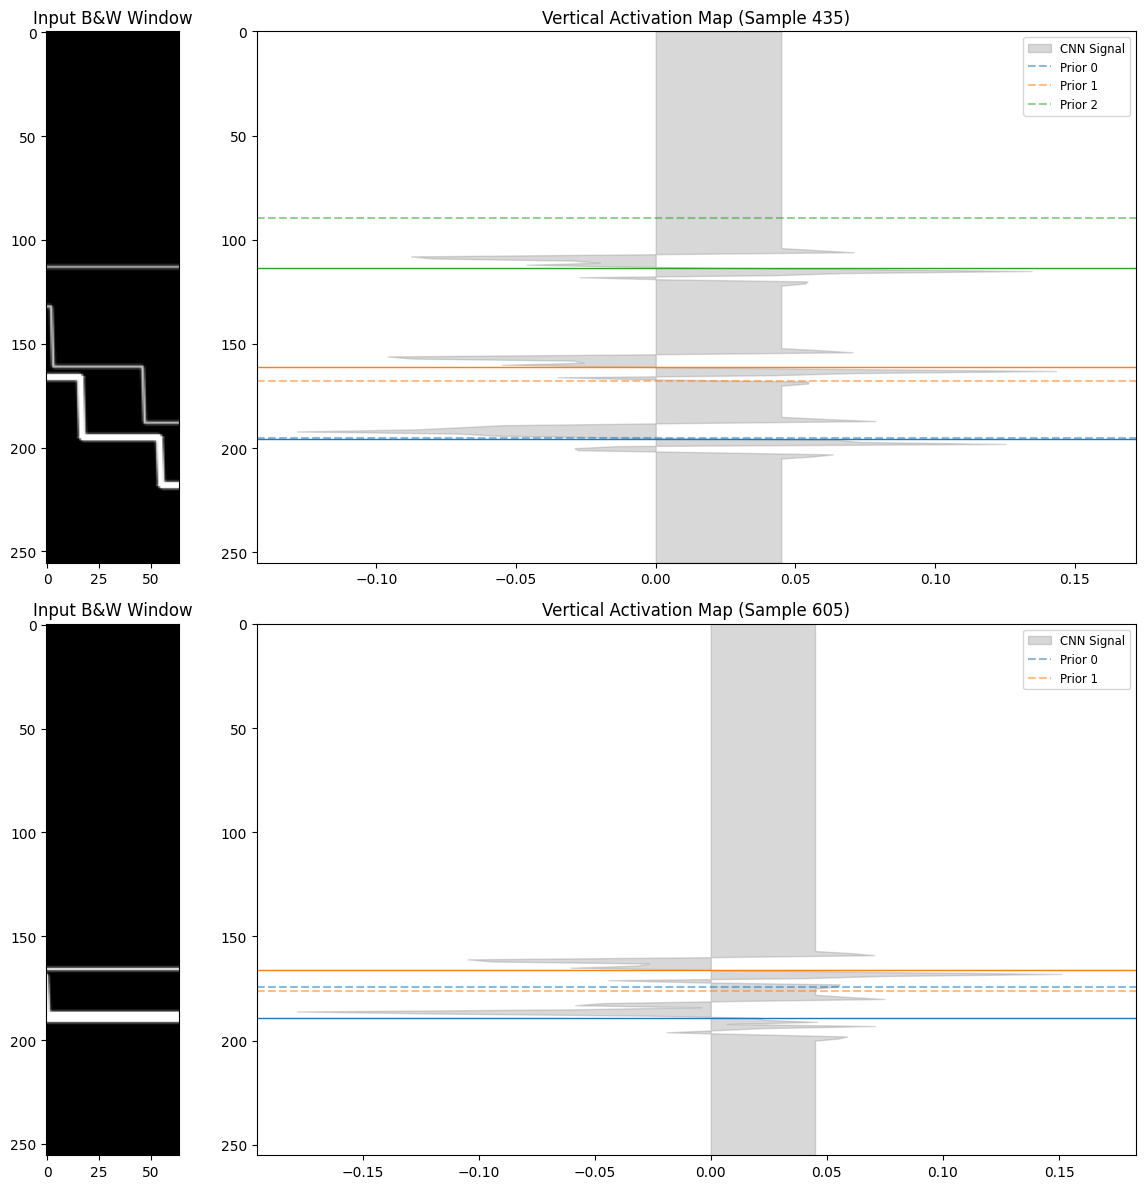

In [172]:
visualize_attention_map(trained_model, val_dataset)

C:\Users\remi_\AppData\Local\Temp\ipykernel_33732\1372713132.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10")


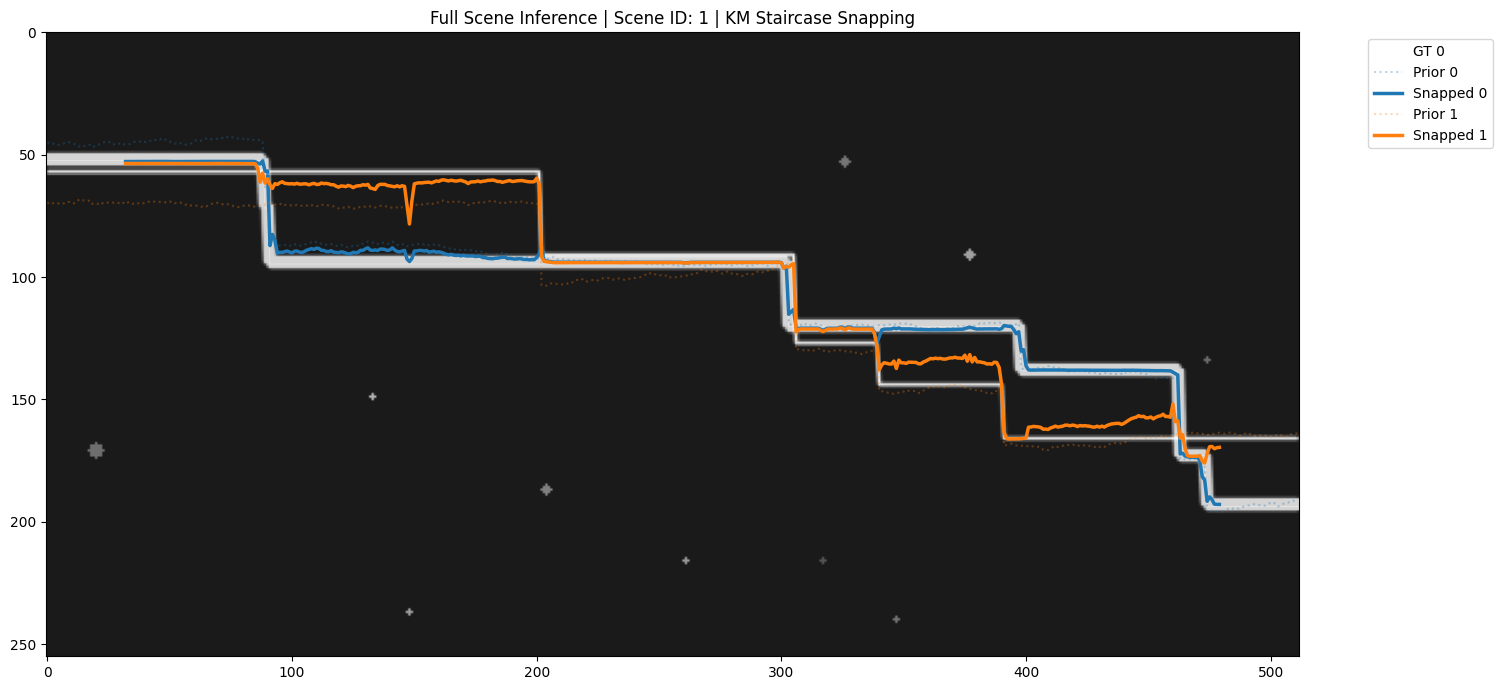

In [185]:
val_dataset = KMRealisticHybridDataset(n_scenes=5, samples_per_scene=50)

visualize_full_image_inference(model, val_dataset)

In [ ]:
import torch

def load_variable_curve_snapper_weights(
    model,
    pth_path,
    device="cpu",
    strict=True,
):
    """
    Load pretrained weights into a VariableCurveSnapperNet model.

    Args:
        model (nn.Module): Initialized VariableCurveSnapperNet instance.
        pth_path (str): Path to the .pth file.
        device (str or torch.device): Device to map weights to.
        strict (bool): Whether to enforce exact key matching.

    Returns:
        nn.Module: Model with loaded weights.
    """
    checkpoint = torch.load(pth_path, map_location=device)

    # Common patterns: either a raw state_dict or wrapped in a dict
    if isinstance(checkpoint, dict):
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
        elif "model_state_dict" in checkpoint:
            state_dict = checkpoint["model_state_dict"]
        else:
            # Assume the dict itself is a state_dict
            state_dict = checkpoint
    else:
        raise ValueError("Unsupported checkpoint format")

    # Handle DataParallel / DDP checkpoints
    cleaned_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            k = k[len("module."):]
        cleaned_state_dict[k] = v

    model.load_state_dict(cleaned_state_dict, strict=strict)
    model.to(device)
    model.eval()

    return model


In [ ]:
import os

pth = "curve_snapper_validated.pth"

print("Exists:", os.path.exists(pth))
print("Size (MB):", os.path.getsize(pth) / 1024 / 1024)


Exists: True
Size (MB): 46.0


In [ ]:
model = VariableCurveSnapperNet(win_w=64, max_curves=8)
model = load_variable_curve_snapper_weights(
    model,
    "curve_snapper_validated.pth",
    device="cuda",
    strict=True,
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [ ]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def full_image_snapping_inference(
    model,
    image_path,
    points_csv,
    calib,
    win_w=64,
    win_h=256,
    seg_len=5,                 # must match training
    device="cuda",
    save_filename="snapped_output_full.csv",
    plot_filename="snapped_overlay_full.png",
):
    import numpy as np
    import pandas as pd
    import cv2
    import torch
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    assert seg_len % 2 == 1
    seg_r = seg_len // 2

    # -------------------------------------------------
    # 1. Load image + CSV
    # -------------------------------------------------
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape

    df = pd.read_csv(points_csv)

    # -------------------------------------------------
    # 2. Calibration helpers
    # -------------------------------------------------
    def to_px(val, cfg):
        if cfg["mode"] == "log10":
            return cfg["a"] * np.log10(val) + cfg["b"]
        return cfg["a"] * val + cfg["b"]

    def to_data(px, cfg):
        v = (px - cfg["b"]) / cfg["a"]
        return 10 ** v if cfg["mode"] == "log10" else v

    df["x_px"] = df["x"].apply(lambda v: to_px(v, calib["x"]))
    df["y_px"] = df["y"].apply(lambda v: to_px(v, calib["y"]))

    min_x = max(0, int(np.floor(df["x_px"].min())))
    max_x = min(W - 1, int(np.ceil(df["x_px"].max())))

    # -------------------------------------------------
    # 3. Build continuous priors
    # -------------------------------------------------
    series_ids = sorted(df["series_index"].unique())
    priors_full = {}

    for s in series_ids:
        g = df[df["series_index"] == s].sort_values("x_px")
        f = interp1d(g["x_px"], g["y_px"], kind="linear", fill_value="extrapolate")
        priors_full[s] = f(np.arange(W))

    # -------------------------------------------------
    # 4. Pad image horizontally
    # -------------------------------------------------
    pad = win_w // 2
    img_padded = cv2.copyMakeBorder(
        img_rgb, 0, 0, pad, pad, cv2.BORDER_REFLECT
    )

    model.eval()
    model.to(device)

    # -------------------------------------------------
    # 5. Storage: interval votes
    # -------------------------------------------------
    # votes[s][x] = list of predicted y_px values
    votes = {
        s: [ [] for _ in range(W) ]
        for s in series_ids
    }

    # -------------------------------------------------
    # 6. Sliding inference (per series, per center x)
    # -------------------------------------------------
    for xc in range(min_x, max_x + 1):
        x_pad = xc + pad
        x0, x1 = x_pad - pad, x_pad + pad

        for s in series_ids:
            # ---------------------------------------------
            # Anchor window to THIS series prior
            # ---------------------------------------------
            y_center = priors_full[s][xc]
            y_top = int(round(y_center - win_h / 2))
            y_top = max(0, min(y_top, H - win_h))

            crop = img_padded[y_top : y_top + win_h, x0 : x1]
            img_t = (
                torch.from_numpy(crop)
                .permute(2, 0, 1)
                .float()
                .unsqueeze(0)
                / 255.0
            )

            # ---------------------------------------------
            # Prior segment (centered on xc)
            # ---------------------------------------------
            start, end = xc - pad, xc + pad
            if start < 0:
                seg = np.pad(priors_full[s][0:end], (abs(start), 0), mode="edge")
            elif end > W:
                seg = np.pad(priors_full[s][start:W], (0, end - W), mode="edge")
            else:
                seg = priors_full[s][start:end]

            priors_t = torch.zeros((1, 1, win_w))
            priors_t[0, 0] = torch.from_numpy((seg - y_top) / win_h)

            with torch.no_grad():
                y_seg = model(img_t.to(device), priors_t.to(device))[0]  # [1,L]

            y_seg_px = y_seg.squeeze(0).cpu().numpy() * (win_h - 1) + y_top

            # ---------------------------------------------
            # Distribute interval votes
            # ---------------------------------------------
            for j in range(seg_len):
                xj = xc + (j - seg_r)
                if 0 <= xj < W:
                    votes[s][xj].append(y_seg_px[j])

    # -------------------------------------------------
    # 7. Aggregate votes (median = robust)
    # -------------------------------------------------
    snapped = {}

    for s in series_ids:
        ys = []
        for x in range(min_x, max_x + 1):
            if votes[s][x]:
                ys.append(np.median(votes[s][x]))
            else:
                ys.append(priors_full[s][x])
        snapped[s] = np.array(ys)

    # -------------------------------------------------
    # 8. Save + visualize
    # -------------------------------------------------
    rows = []
    plt.figure(figsize=(W / 100, H / 100))
    plt.imshow(img_rgb)
    colors = plt.cm.get_cmap("tab10", len(series_ids))

    for i, s in enumerate(series_ids):
        xs = np.arange(min_x, max_x + 1)
        ys = snapped[s]

        plt.plot(xs, ys, color=colors(i), lw=2, label=f"Series {s}")

        orig = df[df["series_index"] == s]
        plt.scatter(orig["x_px"], orig["y_px"], s=25, color=colors(i), edgecolors="white")

        for x, y in zip(xs, ys):
            rows.append({
                "series": s,
                "x_px": x,
                "y_px": y,
                "y_data": to_data(y, calib["y"]),
            })

    plt.legend()
    plt.savefig(plot_filename, dpi=200, bbox_inches="tight")
    pd.DataFrame(rows).to_csv(save_filename, index=False)

    print(f"Full-image snapping complete. Saved {save_filename}")

def prepare_clean_padded_image(img_rgb, calib, pad_w=32):
    """
    Blanks out everything outside the axis defined by x_axis_y and y_axis_x,
    then applies reflective padding to the horizontal edges.
    """
    H, W, _ = img_rgb.shape
    clean_img = img_rgb.copy()

    # --- 1. Blanking Logic ---
    # Everything to the left of the Y-axis (y_axis_x) becomes white
    y_axis_x = calib['y_axis_x']
    clean_img[:, :y_axis_x, :] = 255

    # Everything below the X-axis (x_axis_y) becomes white
    x_axis_y = calib['x_axis_y']
    clean_img[x_axis_y:, :, :] = 255

    # --- 2. Mirror Padding Logic ---
    # We pad the left and right with a 'mirror' of the image edges
    # This allows the model to 'see' past the edge when snapping the first/last points.
    padded_img = cv2.copyMakeBorder(
        clean_img,
        0, 0,           # No top/bottom padding
        pad_w, pad_w,   # Left/Right padding
        cv2.BORDER_REFLECT
    )

    return padded_img

/tmp/ipython-input-4212921309.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(series_ids))


Full-image snapping complete. Saved snapped_output_full.csv


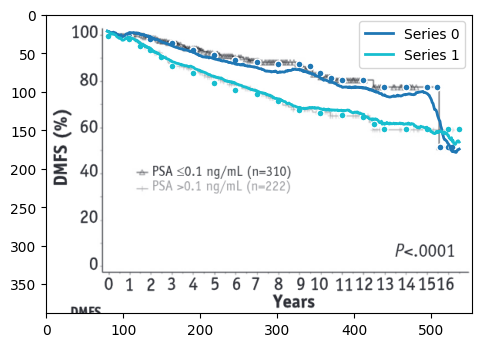

In [ ]:
# Setup your calibration
calibration = {'x': {'a': 27.60645, 'b': 79.76774, 'mode': 'linear'},
               'y': {'a': -3.0, 'b': 328.0, 'mode': 'linear'},
               'x_axis_y': 335,
               'y_axis_x': 72}
# Run the inference
snapped = full_image_snapping_inference(
    trained_model,
    "og_img.png",
    "extracted_points.csv",
    calibration,
    device=device
)

# 'snapped' is now a [K, Width] array of precise pixel coordinates